In [9]:
import pandas as pd
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

Function Definitions and Data Cleaning

In [10]:
def haversine_miles(lat1, lon1, lat2, lon2):
    R = 3958.8  # Earth radius in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    d = 2 * R * np.arcsin(np.sqrt(a))
    return d

In [24]:
df = pd.read_csv('dataset/Zomato Dataset.csv')
df = df.drop("Delivery_person_ID", axis=1)
df["Order_Date"] = pd.to_datetime(df["Order_Date"], format="%d-%m-%Y")
df.head()

# in "Time_Orderd" and Time_Order_picked column, there are multiple invalid times which we will drop 
# 1. force columns to string
df["Time_Orderd"] = df["Time_Orderd"].astype(str)
df["Time_Order_picked"] = df["Time_Order_picked"].astype(str)

# 2. remove invalid 24:xx times
df = df[~df["Time_Orderd"].str.startswith("24:")]
df = df[~df["Time_Order_picked"].str.startswith("24:")]

# 3. keep only rows containing a colon (:)
df = df[df["Time_Orderd"].str.contains(":", na=False)]
df = df[df["Time_Order_picked"].str.contains(":", na=False)]

# 4. trim seconds (HH:MM:SS → HH:MM)
df["Time_Orderd"] = df["Time_Orderd"].str.slice(0, 5)
df["Time_Order_picked"] = df["Time_Order_picked"].str.slice(0, 5)

# 5. convert to datetime
df["Time_Orderd"] = pd.to_datetime(df["Time_Orderd"], format="%H:%M").dt.time
df["Time_Order_picked"] = pd.to_datetime(df["Time_Order_picked"], format="%H:%M").dt.time

df["distance_miles"] = haversine_miles(
    df["Restaurant_latitude"],
    df["Restaurant_longitude"],
    df["Delivery_location_latitude"],
    df["Delivery_location_longitude"]
)

df = df.dropna()

df = df[df["distance_miles"] < 1000]

In [25]:
categorical_cols = ["Weather_conditions",
                    "Road_traffic_density",
                    "Type_of_order",
                    "Type_of_vehicle",
                    "Festival",
                    "City"]

df_clean = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

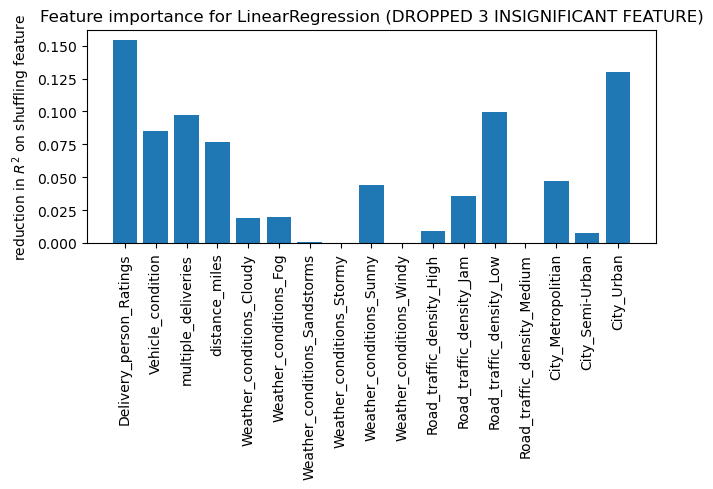

In [26]:
df_after_drop = df.drop(columns=["Festival", "Type_of_order", "Type_of_vehicle"])
categorical_cols = ["Weather_conditions",
                    "Road_traffic_density",
                    "City"]

df_clean_new = pd.get_dummies(df_after_drop, columns=categorical_cols, drop_first=False)
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude', 'Delivery_person_Age'])

model = linear_model.LinearRegression()
model.fit(X, y)
pi = permutation_importance(estimator=model, X=X, y=y, random_state=0)
plt.bar(x=range(X.columns.size), height=pi.importances_mean, tick_label=X.columns)
plt.xticks(rotation='vertical') 
plt.tight_layout()
plt.title('Feature importance for LinearRegression (DROPPED 3 INSIGNIFICANT FEATURE)')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')

Hyperparameter Tuning

In [28]:
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size =0.05, random_state = 0)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

knn = KNeighborsRegressor(metric='euclidean')
param_grid = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10]}

grid_search = GridSearchCV(
    estimator=knn,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)

# 3. Fit on the training data
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_


print("Best CV score (MAE):", best_model.score(X_valid, y_valid))
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best CV score (MAE): 0.7714986276990095
Best params: {'n_neighbors': 6}


In [30]:
X.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'distance_miles', 'Weather_conditions_Cloudy',
       'Weather_conditions_Fog', 'Weather_conditions_Sandstorms',
       'Weather_conditions_Stormy', 'Weather_conditions_Sunny',
       'Weather_conditions_Windy', 'Road_traffic_density_High',
       'Road_traffic_density_Jam', 'Road_traffic_density_Low',
       'Road_traffic_density_Medium', 'City_Metropolitian', 'City_Semi-Urban',
       'City_Urban'],
      dtype='object')

In [8]:
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size =0.05, random_state = 0)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)


gb = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'max_depth': [5, 7, 10],  # Maximum depth of the individual regression estimators
}


grid_search = GridSearchCV(
    estimator=gb,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

print("Best CV score (MAE):", best_model.score(X_valid, y_valid))
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best CV score (MAE): 0.8351712943523896
Best params: {'max_depth': 7, 'n_estimators': 100}


In [9]:
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size =0.05, random_state = 0)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages
    'max_depth': [5, 7, 10],  # Maximum depth of the individual regression estimators
}


grid_search = GridSearchCV(
    estimator=rf,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

print("Best CV score (MAE):", best_model.score(X_valid, y_valid))
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best CV score (MAE): 0.830865563198842
Best params: {'max_depth': 10, 'n_estimators': 100}


In [10]:
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude', 'Delivery_person_Ratings'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size =0.05, random_state = 0)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

id3 = DecisionTreeRegressor()
param_grid = {
    'max_depth': [5, 7, 10],  # Maximum depth of the individual regression estimators
}


grid_search = GridSearchCV(
    estimator=id3,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

print("Best CV score (MAE):", best_model.score(X_valid, y_valid))
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best CV score (MAE): 0.8052689809913085
Best params: {'max_depth': 10}


In [11]:
ridge_reg = linear_model.Lasso()

param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}


grid_search = GridSearchCV(
    estimator=ridge_reg,              # your pipeline
    param_grid=param_grid,
    cv=5,                       # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # or 'neg_root_mean_squared_error'
    n_jobs=-1,                  # use all cores
    verbose=2
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

print("Best CV score (MAE):", best_model.score(X_valid, y_valid))
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best CV score (MAE): 0.5390973590053889
Best params: {'alpha': 0.01}


Stacking The Models

In [12]:
all_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', 
               'Weather_conditions', 'Road_traffic_density', 'City', "distance_miles"]
numeric_features = ['Delivery_person_Age', 'Vehicle_condition', 'multiple_deliveries', "distance_miles"]
categorical_features = ['Weather_conditions', 'Road_traffic_density', 'City']

estimators = [
    ('GradientBooosting', GradientBoostingRegressor(max_depth = 7, n_estimators = 100, random_state = 0)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=10, random_state=0)),
    ('Knn', KNeighborsRegressor(metric='euclidean', n_neighbors=6)),
]

X = df[all_features]
y = df['Time_taken (min)']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state = 0, test_size=0.05)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, random_state = 0, test_size=0.5)


preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ]
)

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor(max_depth=10, n_estimators=100, random_state=0)))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Delivery_person_Age',
                                                   'Vehicle_condition',
                                                   'multiple_deliveries',
                                                   'distance_miles']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Weather_conditions',
                                                   'Road_traffic_density',
                                                   'City'])])),
                ('model',
                 StackingRegressor(estimators=[('GradientBooosting',
                                                GradientBoostingRegressor(max_depth=7,
                                                                          random_state=0)),
                                               ('DecisionTree',
                                                DecisionTreeRegressor(max_depth=10,
                                                                      random_state=0)),
                                               ('Knn',
                                                KNeighborsRegressor(metric='euclidean',
                                                                    n_neighbors=6))],
                                   final_estimator=RandomForestRegressor(max_depth=10,
                                                                         random_state=0)))])

In [13]:
print(f"{clf.score(X_valid, y_valid):.3}")

0.817


In [21]:
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude', 'Delivery_person_Ratings'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size =0.1, random_state = 0)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 0)

estimators = [
    ('GradientBooosting', GradientBoostingRegressor(max_depth = 7, n_estimators = 100)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=10, random_state=0)),
    ('Knn', KNeighborsRegressor(metric='euclidean', n_neighbors=6))
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor(max_depth=10, n_estimators=100)
)



clf.fit(X_train, y_train)
print(f"{clf.score(X_valid, y_valid):.3}")

0.803


In [22]:
# Predictions
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
y_test_pred = clf.predict(X_test)

# MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_valid = mean_squared_error(y_valid, y_valid_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Train MSE:", mse_train)
print("Valid MSE:", mse_valid)

Train MSE: 14.614770287283584
Valid MSE: 16.24495334642879


In [23]:
print(f"final test accuracy:{clf.score(X_test, y_test):.3}")
print("Test MSE:", mse_test)

final test accuracy:0.812
Test MSE: 16.625113603991487


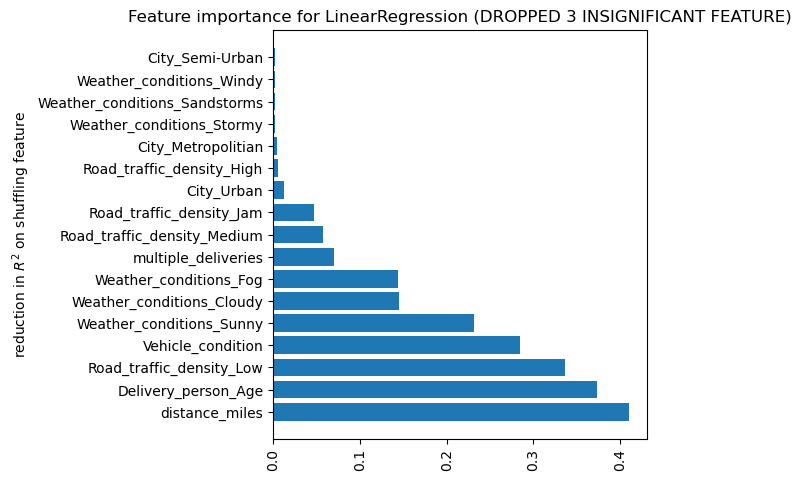

In [17]:
df_clean_new = pd.get_dummies(df_after_drop, columns=categorical_cols, drop_first=False)
y = df_clean_new["Time_taken (min)"]
X = df_clean_new.drop(columns=["Time_taken (min)", "ID", "Time_Orderd", 
                            "Time_Order_picked", "Order_Date", 'Restaurant_latitude', 
                           'Restaurant_longitude', 'Delivery_location_latitude', 
                           'Delivery_location_longitude', 'Delivery_person_Ratings'])
estimators = [
    ('GradientBooosting', GradientBoostingRegressor(max_depth = 7, n_estimators = 100)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=10, random_state=0)),
    ('Knn', KNeighborsRegressor(metric='euclidean', n_neighbors=6))
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=RandomForestRegressor(max_depth=10, n_estimators=100)
)

clf.fit(X, y)
pi = permutation_importance(estimator=clf, X=X, y=y, random_state=0)
importances = pd.DataFrame({
    "feature": X.columns,
    "importance" : pi.importances_mean
})

importances = importances.sort_values("importance", ascending=False)
plt.barh(importances["feature"], importances["importance"])
plt.xticks(rotation='vertical') 
plt.tight_layout()
plt.title('Feature importance for LinearRegression (DROPPED 3 INSIGNIFICANT FEATURE)')
_ = plt.ylabel(r'reduction in $R^2$ on shuffling feature')